In [ ]:
# import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# define file paths
ANALYSIS_PATH = "./data_analysis/"
DEMO_DATA_PATH = "./Sepsis_plt/by_year/demographic/demographic_SIC_all.csv"

In [3]:
def analyze_patient_count(master_file): # analyze unique patients per year (Reference Key)
    if not os.path.exists(master_file):
        print(f"File {master_file} does not exist.")
        return
    
    try:
        df = pd.read_csv(master_file)
        if 'Reference Key' in df.columns and 'Year' in df.columns:
            grouped_df = df.groupby('Year')['Reference Key'].nunique().reset_index(name='Unique_Patients')
    except Exception as e:
        print(f"Error reading {master_file}: {e}")
        return
    
    if grouped_df.empty:
        print("No data available to plot.")
        return

    plt.figure(figsize=(12, 8)) # plot unique patients per year
    years = grouped_df['Year']
    unique_patients = grouped_df['Unique_Patients']
    bars = plt.bar(range(len(years)), unique_patients, alpha=1, color='lightgreen', edgecolor='darkgreen', linewidth=0.5, zorder=2)
    plt.xlabel('Year')
    plt.ylabel('Number of Unique Patients')
    plt.title('Unique Patients per Year (Reference Key)')
    plt.xticks(range(len(years)), years, rotation=45)
    plt.grid(True, alpha=0.3, zorder=1)
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height):,}', ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join(ANALYSIS_PATH, 'unique_patients_per_year.png'), dpi=150, bbox_inches='tight') # save plot
    plt.show()
    print(f"Plot saved to {os.path.join(ANALYSIS_PATH, 'unique_patients_per_year.png')}")
    output_file = os.path.join(ANALYSIS_PATH, 'unique_patients_per_year.csv')
    grouped_df.to_csv(output_file, index=False) # save csv
    print(f"Unique patient counts saved to {output_file}")


In [4]:
def load_demographic_data(): # load demographic data
    if not os.path.exists(DEMO_DATA_PATH):
        print(f"Demographic data file {DEMO_DATA_PATH} does not exist.")
        return None
    try:
        df = pd.read_csv(DEMO_DATA_PATH)
        return df
    except Exception as e:
        print(f"Error reading demographic data: {e}")
        return None

In [5]:
def filter_unique_patients(df): # filter unique patients by Reference Key
    if 'Reference Key' not in df.columns:
        return df
    return df.drop_duplicates(subset=['Reference Key']) # keeping first occurrence

In [14]:
def analyze_age(year): # analyze age distribution
    df = load_demographic_data()
    df = filter_unique_patients(df)

    age_stats = []
    years = sorted(df['Year'].unique())
    if year == 0: # filter off
        for year in years: # compute age statistics per year
            year_df = df[df['Year'] == year]
            ages = year_df['Admission Age (Year) (episode based)'].dropna()
            if not ages.empty:
                mean_age = ages.mean()
                median_age = ages.median()
                min_age = ages.min()
                max_age = ages.max()
                std_age = ages.std()
                age_stats.append({'Year': year, 'Mean_Age': mean_age, 'Median_Age': median_age, 'Min_Age': min_age, 'Max_Age': max_age, 'Std_Age': std_age})
                
        plt.figure(figsize=(12, 8)) # plot mean age per year
        plt.plot([stat['Year'] for stat in age_stats], [stat['Mean_Age'] for stat in age_stats], marker='o', color='orange', label='Mean Age', zorder=2)
        plt.xlabel('Year')
        plt.ylabel('Mean Age')
        plt.title('Mean Age of Patients per Year')
        plt. legend()
        plt.grid(True, alpha=0.3, zorder=1)
        plt.tight_layout()
        plt.savefig(os.path.join(ANALYSIS_PATH, 'mean_age_trend.png'))
        plt.show()

        plt.figure(figsize=(12, 6)) # plot histogram
        plt.hist(df['Admission Age (Year) (episode based)'].dropna(), bins=30, color='purple', alpha=1, edgecolor='black', zorder=2)
        plt.xlabel('Age')
        plt.ylabel('Number of Patients')
        plt.title('Age Distribution of Patients')
        plt.grid(True, alpha=0.3, zorder=1)
        plt.tight_layout()
        plt.savefig(os.path.join(ANALYSIS_PATH, 'age_distribution_histogram.png'))
        plt.show()

        output_file = os.path.join(ANALYSIS_PATH, 'age_statistics.csv')
        pd.DataFrame(age_stats).to_csv(output_file, index=False) # save csv
        print(f"Age statistics saved to {output_file}")
        
    else: # filter on specific year
        year_df = df[df['Year'] == year]
        ages = year_df['Admission Age (Year) (episode based)'].dropna()
        if not ages.empty:
            mean_age = ages.mean()
            median_age = ages.median()
            min_age = ages.min()
            max_age = ages.max()
            std_age = ages.std()
            print(f"Age statistics for year {year}: Mean: {mean_age}, Median: {median_age}, Min: {min_age}, Max: {max_age}, Std: {std_age}")
            plt.figure(figsize=(12, 6)) # plot histogram
            plt.hist(year_df['Admission Age (Year) (episode based)'].dropna(), bins=30, color='purple', alpha=1, edgecolor='black', zorder=2)
            plt.xlabel('Age')
            plt.ylabel('Number of Patients')
            plt.title('Age Distribution of Patients')
            plt.grid(True, alpha=0.3, zorder=1)
            plt.tight_layout()
            plt.savefig(os.path.join(ANALYSIS_PATH, f"age_distribution_histogram_{year}.png"))
            plt.show()
        else:
            print(f"No age data available for year {year}.")

In [7]:
def analyze_sex(): # analyze sex distrubtion
    df = load_demographic_data()
    df = filter_unique_patients(df)

    plt.figure(figsize=(8, 6)) # pie chart
    sex_counts = df['Sex'].value_counts()
    plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightpink'], explode=(0.01, 0.01))
    plt.title('Sex Distribution')
    plt.tight_layout()
    plt.savefig(os.path.join(ANALYSIS_PATH, 'sex_distribution_pie.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    grouped_df = df.groupby(['Year', 'Sex']).size().unstack(fill_value=0)
    male_count = grouped_df['M'] # count sex by year
    female_count = grouped_df['F']
    total_count = male_count + female_count

    plt.figure(figsize=(12, 8)) # line chart for trend
    years = grouped_df.index
    plt.plot(years, male_count, marker='o', linewidth=2.5, label='Male', color='blue', markersize=8, zorder=2)
    plt.plot(years, female_count, marker='o', linewidth=2.5, label='Female', color='pink', markersize=8, zorder=2)
    plt.xlabel('Year')
    plt.ylabel('Number of Patients')
    plt.title('Sex Distribution Trend')
    plt.legend()
    plt.grid(True, alpha=0.3, zorder=1)
    plt.tight_layout()
    plt.savefig(os.path.join(ANALYSIS_PATH, 'sex_distribution_trend.png'), dpi=150, bbox_inches='tight')
    plt.show()

    M_Pct = (male_count / total_count * 100).fillna(0) # percentage by year
    F_Pct = (female_count / total_count * 100).fillna(0)

    plt.figure(figsize=(12, 8)) # stacked bar chart for percentage trend
    bar_width = 0.6 
    plt.bar(years, M_Pct, color='blue', alpha=0.7, label='Male %', edgecolor='darkblue', linewidth=1, width=bar_width)
    plt.bar(years, F_Pct, bottom=M_Pct, color='pink', alpha=0.7, label='Female %', edgecolor='darkred', linewidth=1, width=bar_width)
    plt.xlabel('Year')
    plt.ylabel('Percentage (%)')
    plt.title('Sex Distribution Trend - Stacked Bar Chart')
    plt.legend()
    plt.grid(True, alpha=0.3, zorder=1, axis='y')
    plt.ylim(0, 100)
    plt.xticks(years, rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(ANALYSIS_PATH, 'sex_distribution_pct.png'), dpi=150, bbox_inches='tight')
    plt.show()

    output_file = os.path.join(ANALYSIS_PATH, 'sex_analysis.csv')
    grouped_df.to_csv(output_file) # save csv
    print(f"Sex analysis saved to {output_file}")

In [8]:
def analyze_mortality(): # analyze mortality rate
    df = load_demographic_data()
    df = filter_unique_patients(df)

    death_counts = df['Episode Death (Y/N)'].value_counts()
    total_counts = len(df)
    for status, count in death_counts.items(): # display overall death percentage
        print(f"Death Status: {status}, Count: {count}, Percentage: {count / total_counts * 100:.2f}%")

    grouped_df = df.groupby('Year')['Episode Death (Y/N)'].value_counts().unstack(fill_value=0)
    death_counts = grouped_df.get('Y', pd.Series(0, index=grouped_df.index))
    total_counts = grouped_df.sum(axis=1)
    mortality_rate = (death_counts / total_counts * 100).fillna(0)

    plt.figure(figsize=(12, 8)) # plot mortality rate trend
    years = grouped_df.index
    plt.plot(years, mortality_rate, marker='o', color='red', label='Mortality Rate (%)', zorder=2)
    plt.xlabel('Year')
    plt.ylabel('Mortality Rate (%)')
    plt.title('Mortality Rate per Year')
    plt.grid(True, alpha=0.3, zorder=1)
    plt.savefig(os.path.join(ANALYSIS_PATH, 'mortality_rate_trend.png'), dpi=150, bbox_inches='tight')
    plt.show()

    output_file = os.path.join(ANALYSIS_PATH, 'mortality_rate.csv')
    mortality_rate_df = pd.DataFrame({'Year': mortality_rate.index, 'Mortality_Rate_Pct': mortality_rate.values})
    mortality_rate_df.to_csv(output_file, index=False) # save csv
    print(f"Mortality rate data saved to {output_file}")

In [1]:
def analyze_death_cause(): # analyze main and secondary death causes
    df = load_demographic_data()
    df = filter_unique_patients(df)

    main_death_cause_counts = df['Death Cause (Main Cause)'].value_counts()
    output_file = os.path.join(ANALYSIS_PATH, 'main_death_cause_distribution.csv')
    main_death_cause_counts.to_csv(output_file) # save csv
    print(f"Death cause distribution saved to {output_file}")

    main_death_cause_counts = df.groupby(['Year', 'Death Cause (Main Cause)']).size().unstack(fill_value=0) # top main death causes by year
    output_file = os.path.join(ANALYSIS_PATH, 'main_death_cause_by_year.csv')
    main_death_cause_counts.to_csv(output_file) # save csv
    print(f"Main death cause by year saved to {output_file}")

    supp_death_cause_counts = df['Death Cause (Supplementary Cause)'].value_counts()
    output_file = os.path.join(ANALYSIS_PATH, 'supplementary_death_cause_distribution.csv')
    supp_death_cause_counts.to_csv(output_file) # save csv
    print(f"Supplementary death cause distribution saved to {output_file}")

    supp_death_cause_counts = df.groupby(['Year', 'Death Cause (Supplementary Cause)']).size().unstack(fill_value=0) # top supplementary death causes by year
    output_file = os.path.join(ANALYSIS_PATH, 'supplementary_death_cause_by_year.csv')
    supp_death_cause_counts.to_csv(output_file) # save csv
    print(f"Supplementary death cause by year saved to {output_file}")

In [ ]:
def analyze_dxpx(): # analyze diagnosis and procedure codes
    df = load_demographic_data()
    df = filter_unique_patients(df)

    dx_counts = df['Dx/Px Description (HAMDCT)'].value_counts()
    output_file = os.path.join(ANALYSIS_PATH, 'dxpx_distribution.csv')
    dx_counts.to_csv(output_file) # save csv
    print(f"Dx/Px distribution saved to {output_file}")

    dx_counts = df.groupby(['Year', 'Dx/Px Description (HAMDCT)']).size().unstack(fill_value=0) # top dx/px by year
    output_file = os.path.join(ANALYSIS_PATH, 'dxpx_by_year.csv')
    dx_counts.to_csv(output_file) # save csv
    print(f"Dx/Px by year saved to {output_file}")

In [76]:
def analyze_race(): # analyze race distribution
    df = load_demographic_data()
    df = filter_unique_patients(df)

    race_counts = df['Race Description'].value_counts()
    output_file = os.path.join(ANALYSIS_PATH, 'race_distribution.csv')
    race_counts.to_csv(output_file) # save csv
    print(f"Race distribution saved to {output_file}")

In [78]:
def analyze_institution(): # analyze institution distribution
    df = load_demographic_data()
    df = filter_unique_patients(df)

    institution_counts = df['Institution (IPAS)'].value_counts()
    output_file = os.path.join(ANALYSIS_PATH, 'institution_distribution.csv')
    institution_counts.to_csv(output_file) # save csv
    print(f"Institution distribution saved to {output_file}")

In [16]:
def analyze_readmission(): # analyze readmission rates
    df = load_demographic_data()

    admission_counts = df.groupby('Reference Key')['Year'].nunique()
    single_admission = (admission_counts == 1).sum()
    double_admissions = (admission_counts == 2).sum()
    triple_admissions = (admission_counts == 3).sum()
    multiple_admissions = (admission_counts > 3).sum()

    print(f"Patients with single admission: {single_admission}")
    print(f"Patients with double admissions: {double_admissions}")
    print(f"Patients with triple admissions: {triple_admissions}")
    print(f"Patients with more than three admissions: {multiple_admissions}")

    readmitted_patients = admission_counts[admission_counts > 1].index.tolist()
    readmission_df = pd.DataFrame({
        'Reference Key': readmitted_patients,
        'Admission_Count': [admission_counts[patient] for patient in readmitted_patients]
    })

    output_file = os.path.join(ANALYSIS_PATH, 'readmitted_patients.csv')
    readmission_df.to_csv(output_file, index=False) # save csv
    print(f"List of readmitted patients saved to {output_file}")

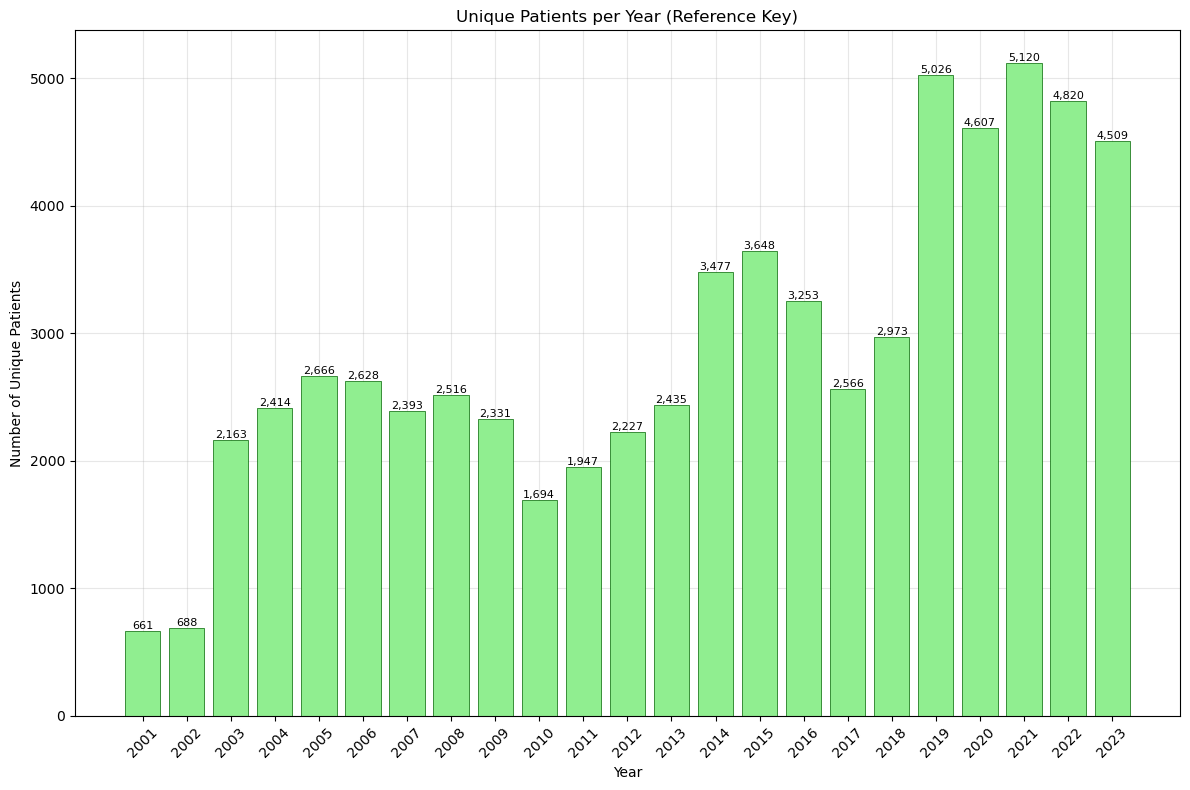

Plot saved to ./data_analysis/unique_patients_per_year.png
Unique patient counts saved to ./data_analysis/unique_patients_per_year.csv


In [ ]:
analyze_patient_count("./Sepsis_plt/by_year/plt/plt_SIC_all.csv") # specify master file to count

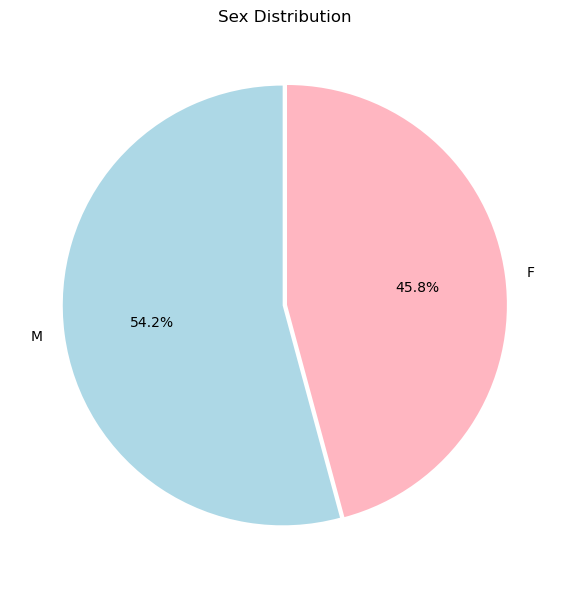

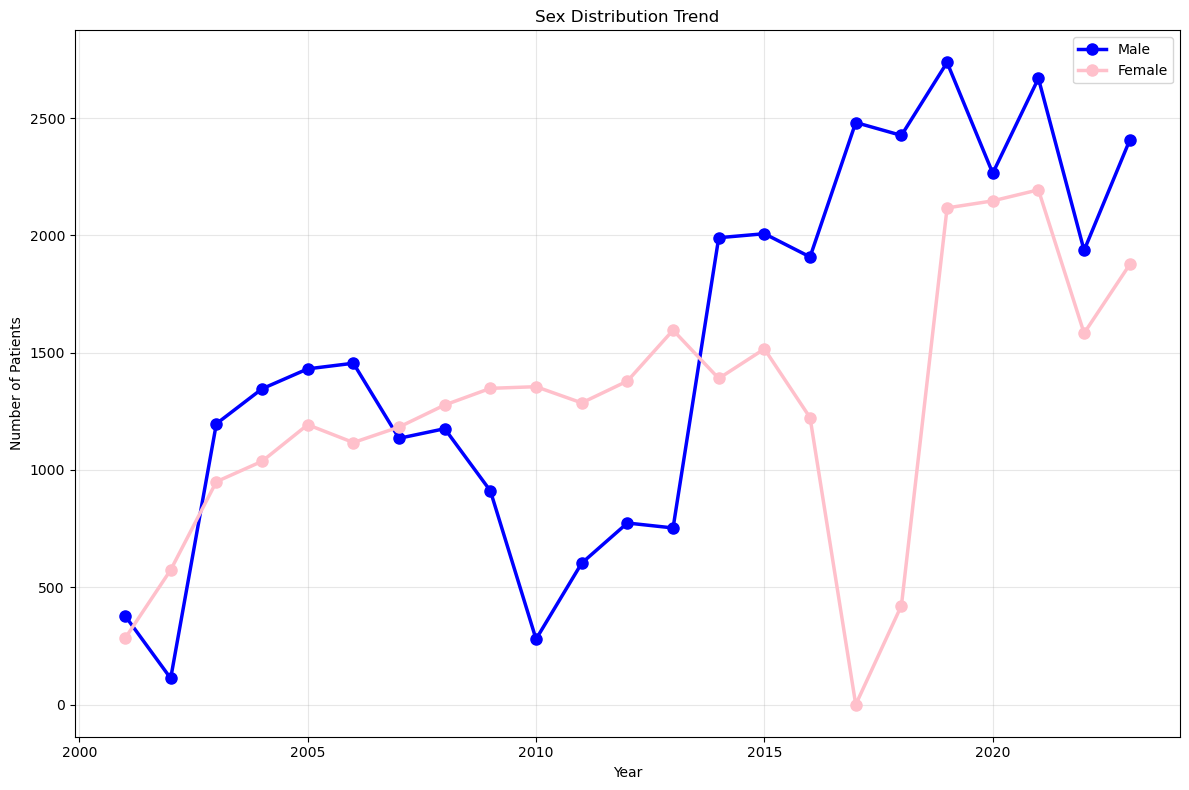

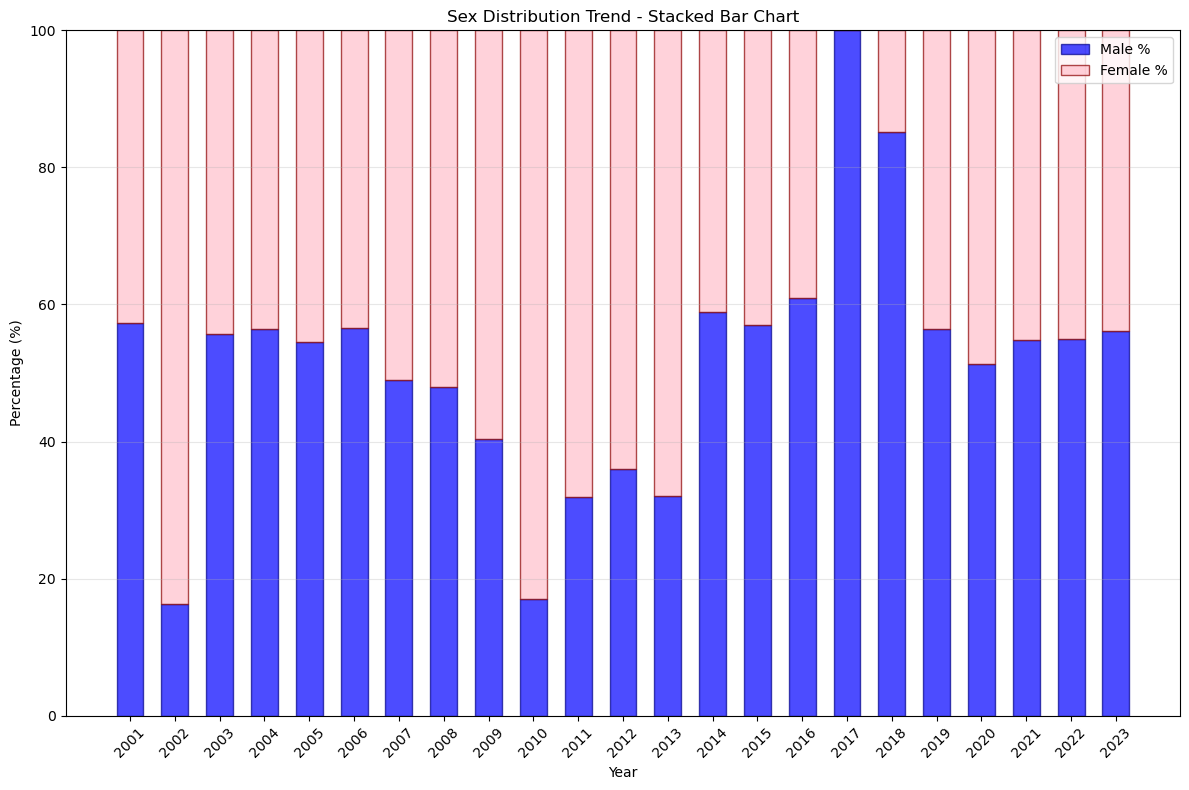

Sex analysis saved to ./data_analysis/sex_analysis.csv


In [ ]:
analyze_sex()

Age statistics for year 2019: Mean: 67.18355995055624, Median: 68.0, Min: 18, Max: 105, Std: 16.930491759625564


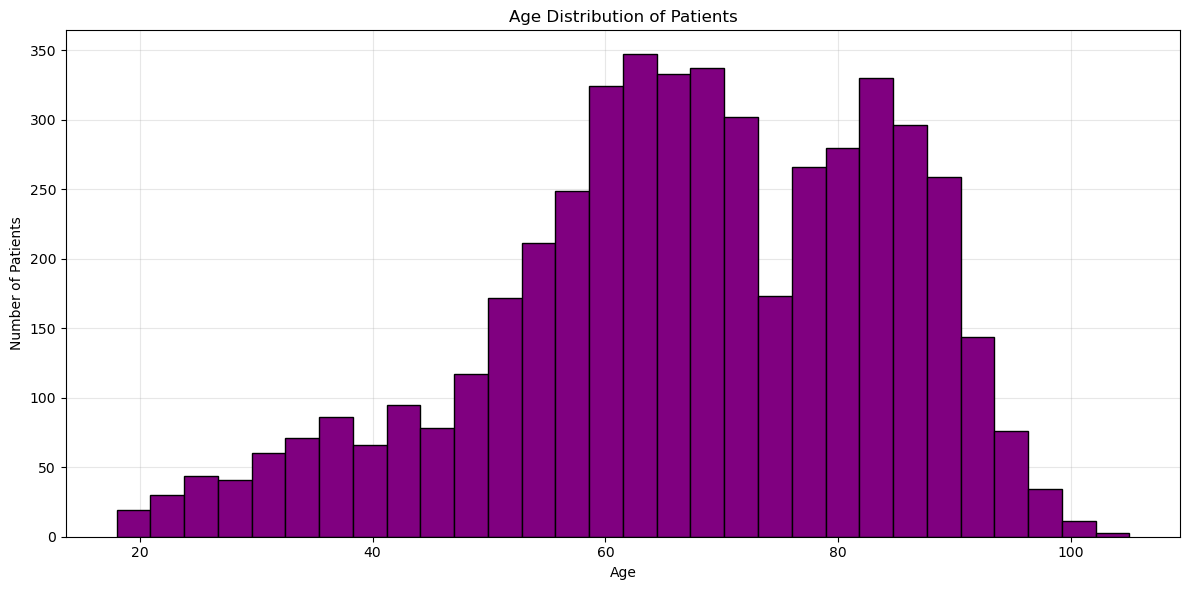

In [15]:
year = 2019 # specify year if needed, 0 disables year filter
analyze_age(year)

Death Status: N, Count: 41964, Percentage: 66.17%
Death Status: Y, Count: 21428, Percentage: 33.79%


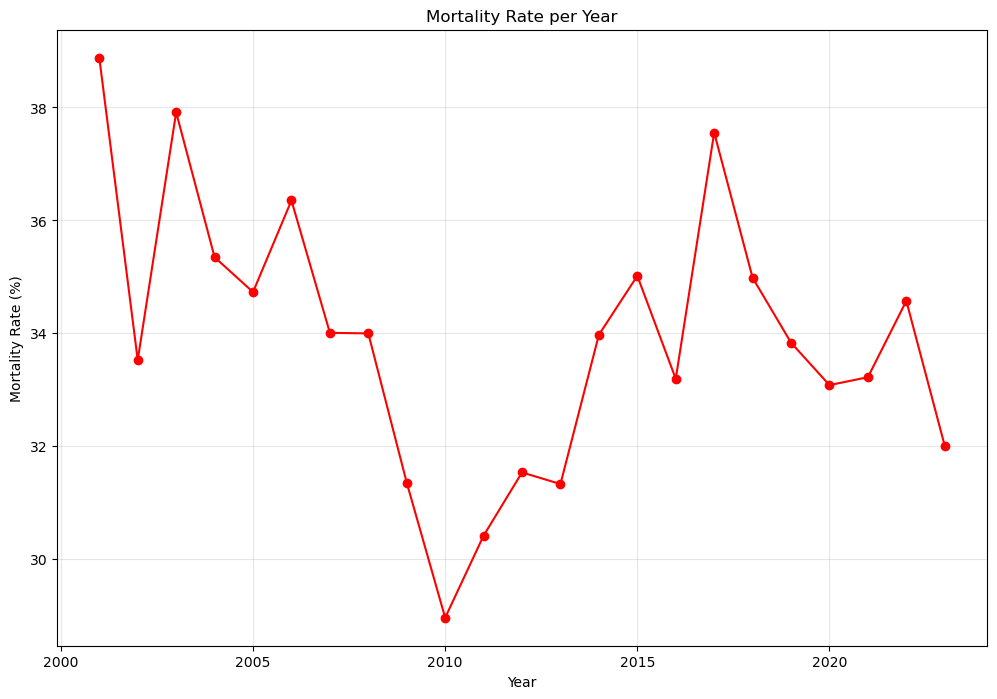

In [75]:
analyze_mortality()

In [9]:
analyze_death_cause()
analyze_dxpx()
analyze_race()
analyze_institution()

Death cause distribution saved to ./data_analysis/main_death_cause_distribution.csv
Main death cause by year saved to ./data_analysis/main_death_cause_by_year.csv
Supplementary death cause distribution saved to ./data_analysis/supplementary_death_cause_distribution.csv
Supplementary death cause by year saved to ./data_analysis/supplementary_death_cause_by_year.csv


NameError: name 'analyze_dxpx' is not defined

In [17]:
analyze_readmission()

Patients with single admission: 61379
Patients with double admissions: 1905
Patients with triple admissions: 116
Patients with more than three admissions: 21
List of readmitted patients saved to ./data_analysis/readmitted_patients.csv
